## T5 трансформер для перевода с немецкого на английский

Сегодня вы поработаете над настоящей задачей NLP и попробуете обучить трансформер переводить короткие предложения с английского на немецкий.

Токенизацию и блоки трансформера писать не придётся — будем пользоваться библиотекой `transformers`.

Наши задачи:
- Познакомиться с наиболее популярным методом токенизации текстов — byte pair encoding
- Научиться пользоваться токенизатором из `transformers`
- Подготовить даннные
- Обучить готовую архитектуру T5-small под нашу задачу
- Исследовать разные стратегии декодирования с помощью обученной модели

In [13]:
!pip install datasets transformers[sentencepiece]
!pip install sentencepiece

zsh:1: no matches found: transformers[sentencepiece]
  Obtaining dependency information for sentencepiece from https://files.pythonhosted.org/packages/79/91/b54a528e0789cd7986341ed3909bec56365c3b672daef8b10aa4098238f0/sentencepiece-0.2.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import math
from pathlib import Path
from typing import cast

import lightning as L
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer

from datasets import load_dataset, load_from_disk

/Users/tsagoll/ML_Last_HW/pythonProject3/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
torch.manual_seed(42)

#### Готовим данные

In [7]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

In [9]:
train_dataset[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

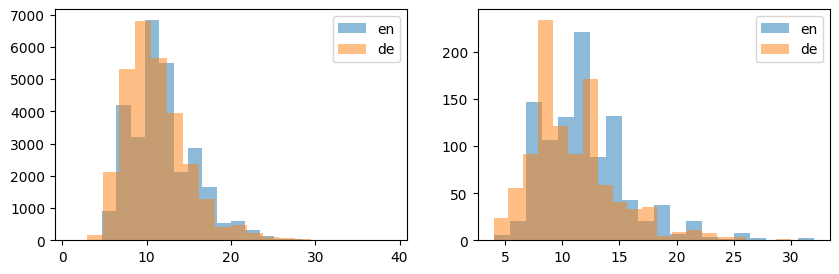

In [8]:
import matplotlib.pyplot as plt


def length_histogram(dataset, ax, bins=20) -> None:
    en_lengths = []
    de_lengths = []
    for sample in dataset:
        en_lengths.append(len(sample["en"].split(" ")))
        de_lengths.append(len(sample["de"].split(" ")))

    ax.hist(en_lengths, alpha=0.5, bins=bins, label="en")
    ax.hist(de_lengths, alpha=0.5, bins=bins, label="de")
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
length_histogram(train_dataset, axes[0])
length_histogram(test_dataset, axes[1])

Оставим только сравнительно короткие предложения, чтобы можно было чему-то научиться за короткое время

In [9]:
maxlen = 8


def filter_dataset(dataset, maxlen: int) -> list[dict[str, str]]:
    return [
        dataset[i]
        for i in range(len(dataset))
        if len(dataset[i]["en"].split(" ")) <= maxlen
    ]


train_filtered = filter_dataset(train_dataset, maxlen)
test_filtered = filter_dataset(test_dataset, maxlen)

print(len(train_filtered), len(test_filtered))

5144 174


##### Токенизация: byte-pair encoding

Построение:

Начинаем со словаря, состоящего из отдельных символов (начальные токены).
На каждом шаге:
1. Оцениваем частоту всех пар токенов внутри слов, находим самую частую
2. Добавляем её в список токенов и в таблицу слияний
3. Останавливаемся, когда достигаем максимального размера словаря


Применение:

1. Разбиваем текст на символы
2. Находим первое возможное слияние в таблице и применяем его
3. Останавливаемся, когда дальнейшие слияния невозможны

<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/build_merge_table.gif" style="background:white" height="300"/>
<img src="https://lena-voita.github.io/resources/lectures/seq2seq/bpe/bpe_apply.gif" style="background:white" height="300"/>


Реализаций много, мы будем использовать токенизатор  из библиотеки `transformers`, где помимо самого подготовленного токенизатора (`sentencepiece.SentencePieceProcessor`) много полезных методов для кодирования и декодирования.

Добавим при создании новый токен, который будет указывать на начало перевода

In [10]:
tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained(
    "t5-small", padding_size="right", bos_token="</b>", legacy=False
)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [11]:
print("Размер словаря: ", len(tokenizer))

Размер словаря:  32101


Посмотрим на примеры токенов, в них встречаются и целые слова из разных языков, и числительные, и знаки препинания:

In [9]:
import random

random.choices(list(tokenizer.get_vocab().items()), k=10)

[('▁showed', 3217),
 ('▁Saint', 2788),
 ('▁Sonic', 20419),
 ('▁zahlreiche', 9878),
 ('popular', 27302),
 ('▁mathematical', 18913),
 ('likewise', 15340),
 ('▁si', 108),
 ('▁Damage', 26135),
 ('▁choses', 12344)]

Токенизатор в работе: кодирование и декодирование предложений на немецком и английском:

In [12]:
encoded_german = tokenizer.encode(train_dataset[0]["de"])
encoded_english = tokenizer.encode(train_dataset[0]["en"])
print(encoded_german)
print(tokenizer.decode(encoded_german))
print(encoded_english)
print(tokenizer.decode(encoded_english))

[11280, 16815, 7838, 15, 16282, 436, 256, 8671, 35, 16, 74, 13271, 2221, 49, 21162, 3992, 5, 1]
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.</s>
[2759, 1021, 6, 1945, 5069, 7, 33, 1067, 1084, 186, 3, 30271, 5, 1]
Two young, White males are outside near many bushes.</s>


Об упаковке в батчи можно больше не беспокоиться — токенизатор умеет обрабатывать сразу пачку примеров

In [13]:
batch = [train_dataset[i]["en"] for i in range(4)]

encoded_batch = tokenizer.batch_encode_plus(
    batch, padding="longest", return_tensors="pt"
)
print(encoded_batch["input_ids"].shape)
print(encoded_batch.keys())

torch.Size([4, 19])
dict_keys(['input_ids', 'attention_mask'])


Возвращается два значения: `input_ids` — это наши токены, а `attention_mask` — это тензор, равный по размеру батчу токенов, где на месте `pad_token` стоят нули, в остальных позициях — единицы. Это нам понадобится потом.

А ещё можно кодировать сразу входные и выходные данные:

In [14]:
inputs = [train_dataset[i]["en"] + tokenizer.bos_token for i in range(4)]
targets = [train_dataset[i]["de"] for i in range(4)]

encoded_batch = tokenizer(
    inputs, text_target=targets, padding="longest", return_tensors="pt"
)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


Используем это в `collate_fn` для сборки батчей:

In [15]:
def collate_fn(
    tokenizer: T5Tokenizer, batch: list[tuple[str, str]]
) -> tuple[Tensor, Tensor]:
    prompt = tokenizer.bos_token
    inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
    encoded_batch = tokenizer(
        inputs, text_target=targets, padding="longest", return_tensors="pt"
    )
    return encoded_batch

In [16]:
batch = [train_dataset[i] for i in range(4)]
encoded_batch = collate_fn(tokenizer, batch)
print(encoded_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [17]:
print(encoded_batch["input_ids"].shape)
print(encoded_batch["attention_mask"].shape)
print(encoded_batch["labels"].shape)

torch.Size([4, 22])
torch.Size([4, 22])
torch.Size([4, 20])


Всё готово для получения минибатчей из датасетов:

In [18]:
train_loader = DataLoader(
    train_filtered,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)
test_loader = DataLoader(
    test_filtered,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(tokenizer, batch),
)

#### Задание 1 (3 балла). DataModule

Реализуйте подкласс `lightning.LightningDataModule` для работы с обучающим и тестовым датасетами

In [19]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class Multi30kDataset(L.LightningDataModule):
    train_dataset: Dataset
    test_dataset: Dataset
    tokenizer: T5Tokenizer
    def __init__(self, maxlen: int = 0, batch_size: int = 32) -> None:
        super().__init__()
        self.maxlen = maxlen
        self.batch_size = batch_size
        self.tokenizer = T5Tokenizer.from_pretrained(
            "t5-small", padding_size="right", bos_token="</b>", legacy=False
        )

    def prepare_data(self) -> None:
        # Download datasets; this is only called on one process in distributed settings
        load_dataset("bentrevett/multi30k", split="train")
        load_dataset("bentrevett/multi30k", split="test")

    def setup(self, stage: str = None) -> None:
        # Load datasets; called on every process in distributed settings
        if stage == 'fit' or stage is None:
            self.train_dataset = load_dataset("bentrevett/multi30k", split="train")
            self.test_dataset = load_dataset("bentrevett/multi30k", split="test")

            if self.maxlen > 0:
                self.train_dataset = self.filter_dataset(self.train_dataset, self.maxlen)
                self.test_dataset = self.filter_dataset(self.test_dataset, self.maxlen)

    def filter_dataset(self, dataset, maxlen: int) -> list[dict[str, str]]:
        return [
            dataset[i]
            for i in range(len(dataset))
            if len(dataset[i]["en"].split(" ")) <= maxlen
        ]

    def collate_fn(self, batch: list[dict[str, str]]) -> dict[str, Tensor]:
        prompt = self.tokenizer.bos_token
        inputs, targets = zip(*[(pair["de"], prompt + pair["en"]) for pair in batch])
        encoded_batch = self.tokenizer(
            inputs, text_target=targets, padding="longest", return_tensors="pt"
        )
        return encoded_batch

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return self.val_dataloader()

In [20]:
multi30k = Multi30kDataset(maxlen=8, batch_size=12)

#### Задание 2 (6 баллов). Обучение T5

paper: https://arxiv.org/abs/1910.10683

Обучите `t5-small` на наших данных, длительность обучения — на ваше усмотрение. В [документации](https://huggingface.co/docs/transformers/model_doc/t5) вы найдёте примеры использования, которые помогут вам разобраться в интерфейсе модели.

In [23]:
t5 = T5ForConditionalGeneration.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Обернём в `LightningModule`

In [26]:
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class Seq2Seq(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        tokenizer: T5Tokenizer,
        lr: float = 0.001,
    ) -> None:
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr

    def training_step(self, batch: dict[str, Tensor], batch_idx: int) -> STEP_OUTPUT:
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = outputs.loss
        self.log("loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [40]:
from pytorch_lightning.loggers import TensorBoardLogger

#logger = TensorBoardLogger("lightning_logs", name="t5_translation")

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    limit_train_batches=10,
   # logger=logger, 
)
seq2seq = Seq2Seq(t5, multi30k.tokenizer, lr=0.001)
trainer.fit(model=seq2seq, datamodule=multi30k)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M | eval
------------------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)
0         Modules in train mode
277       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


#### Задание 3 (3 балла). Генерация перевода

Сгенерируйте перевод для одного батча из тестового датасета (используйте метод `t5.generate()`), используя разные стратегии декодирования:
- *greedy decoding*
- *multinomial sampling*
- *beam-search multinomial sampling*

Эти стратегии (а также другие стратегии декодирования) можно задавать через `transformers.GenerationConfig`, который можно передать в метод `.generate()` нашей модели.
Выберите параметры, которые, на ваш взгляд, работают лучше всего.

In [51]:
from transformers import GenerationConfig

from transformers import GenerationConfig

greedy_conf = GenerationConfig(
    max_new_tokens=40,
    do_sample=False,
    num_beams=1,     
)

# Multinomial Sampling с изменёнными параметрами
sampling_conf = GenerationConfig(
    max_new_tokens=40,
    do_sample=True,        
    temperature=0.6,       
    top_p=0.85,             
    num_beams=1,           
    no_repeat_ngram_size=2, 
)
beam_sampling_conf = GenerationConfig(
    max_new_tokens=40,
    do_sample=True,           
    temperature=0.7,        
    top_p=0.9,              
    num_beams=8,             
    length_penalty=1.2,      
    no_repeat_ngram_size=3,   
    early_stopping=True,     
)

In [52]:
batch = next(iter(multi30k.test_dataloader()))

try:
    greedy_preds = t5.generate(batch["input_ids"], generation_config=greedy_conf)
    sampling_preds = t5.generate(batch["input_ids"], generation_config=sampling_conf)
    beam_sampling_preds = t5.generate(batch["input_ids"], generation_config=beam_sampling_conf)
except TypeError as e:
    print("Ошибка при генерации:", e)
    print("Проверьте, что batch является словарём с нужными ключами.")
    raise

inputs = multi30k.tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True)
labels = batch["labels"].clone()
labels[labels == -100] = multi30k.tokenizer.pad_token_id  
targets = multi30k.tokenizer.batch_decode(labels, skip_special_tokens=True)

greedy_outputs = multi30k.tokenizer.batch_decode(greedy_preds, skip_special_tokens=True)
sampling_outputs = multi30k.tokenizer.batch_decode(sampling_preds, skip_special_tokens=True)
beam_sampling_outputs = multi30k.tokenizer.batch_decode(beam_sampling_preds, skip_special_tokens=True)

for i in range(len(inputs)):
    print(f"Input {i+1}: {inputs[i]}")
    print(f"Target {i+1}: {targets[i]}")
    print(f"Greedy Output {i+1}: {greedy_outputs[i]}")
    print(f"Sampling Output {i+1}: {sampling_outputs[i]}")
    print(f"Beam Sampling Output {i+1}: {beam_sampling_outputs[i]}")
    print("-" * 80)
# декодируем входы, правильный и сгенерированный перевод с помощью токенизатора и выводим
...

Input 1: Leute Reparieren das Dach eines Hauses.
Target 1: People are fixing the roof of a house.
Greedy Output 1: People are fixing a roof of a house.
Sampling Output 1: People are fixing a roof of ten people.
Beam Sampling Output 1: People are fixing a roof of a house.
--------------------------------------------------------------------------------
Input 2: Ein Typ arbeitet an einem Gebäude.
Target 2: A guy works on a building.
Greedy Output 2: A guy working on a building.
Sampling Output 2: A guy working on a building.
Beam Sampling Output 2: A guy working on a building.
--------------------------------------------------------------------------------
Input 3: Drei Leute sitzen in einer Höhle.
Target 3: Three people sit in a cave.
Greedy Output 3: Thre people are sitting in a höhle.
Sampling Output 3: Thre people are sitting in a höhle.
Beam Sampling Output 3: Thre people are sitting in a cave.
--------------------------------------------------------------------------------
Input 4: 

Ellipsis